In [1]:
from skimage import io
import dlib
import numpy as np
import os
import re
import skimage.transform as tr
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from IPython.core.display import display
from skimage.transform import resize
import pandas as pd
import urllib
import httplib2
import urllib.request


# First step - image downloading

I used 2 datasets: Saint Georges(https://drive.google.com/drive/folders/1hXAjwpBj6shfWd1taWMFpSqelFCzi6KJ) and SoF(https://www.sites.google.com/view/sof-dataset)

SoF dataset is easy to download, just follow the instructions on the site. However, it is not true for Saint Georges. To download them need sent queries to the url

In [ ]:
#
# saint george download
#
georges_path = 'saint george images/georges'
non_georges_path='saint george images/non georges'

georges_url='saint george images/georges/georges.csv'
non_georges_url = 'saint george images/non georges/non_georges.csv'

georges_df = pd.read_csv(georges_url)
non_georges_df = pd.read_csv(non_georges_url)

for i, url in enumerate(georges_df.values):
    h = httplib2.Http('.cache')
    response, content = h.request(url[0])
    out = open(georges_path + '/' + str(i) + '.jpg', "wb")
    out.write(content)
    out.close()

for i, url in enumerate(non_georges_df.values):
    h = httplib2.Http('.cache')
    response, content = h.request(url[0])
    out = open(non_georges_path + '/' + str(i) + '.jpg', "wb")
    out.write(content)
    out.close()



## Resize images
If there is no necessity in the selection of the face, we can just resize images

In [4]:
def resize_images(path,new_path,new_shape):

    folder_names=os.listdir(path)
    os.mkdir(new_path)
    
    for name in folder_names:
        os.mkdir(new_path+'/'+name)

    for folder in folder_names:
        images_names=os.listdir(path+'/'+folder)
        for image_name in images_names:
            image=io.imread(path+'/'+folder+'/'+image_name)
            resized_image=resize(image,new_shape)
            io.imsave(new_path+'/'+folder+'/'+image_name,resized_image,check_contrast=False)


In [7]:
path='saint george images'
new_path='saint georges dataset'
shape=(128,128,3)
#resize_images(path,new_path,shape)

# Second step - face highlighting

Main approach was taken from https://habr.com/ru/post/317798/ . The idea is to take 3 main point of the face and make Affine transformation to wrap face into new position

Main tool - predictor and detector from libraty dlib

### Read computed weights

In [ ]:
face_template_path='preprocess weights/face_template.npy'
dlib_predictor_path="preprocess weights/shape_predictor_68_face_landmarks.dat" 

### Find main points of the face 

It is possible as dlib detector is pre-trained to find face points. It works on segmentation

In [ ]:
path_me="display images/me.jpg"
image=io.imread(path_me)

face_template=np.load(face_template_path)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_predictor_path)

face_rects=list(detector(image,1))
face_rect=face_rects[0]

points=predictor(image,face_rect)                         
landmarks=np.array(list(map(lambda p: [p.x,p.y],points.parts())))

### Lets look where points are located

In [ ]:
photo=Image.open(path_me)  
pix=photo.load()            
draw=ImageDraw.Draw(photo) 
N=1

for point in landmarks:     
    draw.ellipse(((point[0]-N,point[1]-N),(point[0]+N,point[1]+N)),fill=(0,139,139))

plt.figure(figsize=(7,7))
#plt.imshow(photo)

### Choose 3 main points

Now we choose 3 main point on the image. It's not difficult as we know indeces of those points. Then to use Affine transformatiom need to choose 3 points, where the image would be wrapped

In [ ]:
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]                         
proper_landmarks = 227 * face_template[INNER_EYES_AND_BOTTOM_LIP] 
current_landmarks = landmarks[INNER_EYES_AND_BOTTOM_LIP]          

### Draw 3 main point on the face

In [ ]:
photo=Image.open(path_me)
pix=photo.load()
draw=ImageDraw.Draw(photo)
for point in current_landmarks:

    draw.ellipse(((point[0]-N,point[1]-N),(point[0]+N,point[1]+N)),fill=(255,0,0))
plt.figure(figsize=(7,7))
#plt.imshow(photo)

### Mathematical view

The Affine transformation equetion consists of 2 matrices of points and T - transformation. $X^1, Y^1$ are points on original image and $X^0, Y^0$ are points on new, wrapped image

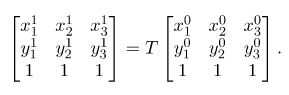

In [8]:
path_matrix="display images/matrix.jpg"
image_matrix=Image.open(path_matrix)
display(image_matrix)

### Affine transform

In [ ]:
size=256
A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
T = np.linalg.solve(A, B).T

wrapped = tr.warp(
image,
tr.AffineTransform(T).inverse,
output_shape=(size, size),
mode='constant',
cval=0,
preserve_range=True
)
im = Image.fromarray(wrapped.astype(np.uint8))
#display(im)

## Bring together all methods


In [ ]:

def preprocess_sof(path,new_path,face_template_path,dlib_predictor_path):

    files_names=os.listdir(path)
    folder_names=list(set([ name[:4] for name in files_names]))

    os.mkdir(new_path)
    for i,name in enumerate(folder_names):
        os.mkdir(new_path+'/'+str(i))
    size=128
        
    face_template=np.load(face_template_path)
    predictor=dlib.shape_predictor(dlib_predictor_path)
    detector=dlib.get_frontal_face_detector()
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    
    for name in files_names:
        image=io.imread(path+'/'+name)

        face_rects=list(detector(image,1))
        try:
            face_rect=face_rects[0]

            points=predictor(image,face_rect)
            landmarks=np.array(list(map(lambda p: [p.x,p.y],points.parts())))

            proper_landmarks=size*face_template[INNER_EYES_AND_BOTTOM_LIP]
            current_landmarks = landmarks[INNER_EYES_AND_BOTTOM_LIP]

            A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
            B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
            T = np.linalg.solve(A, B).T

            wrapped = tr.warp(
            image,
            tr.AffineTransform(T).inverse,
            output_shape=(size, size),
            mode='constant',
            cval=0,
            preserve_range=True
            )
            im = Image.fromarray(wrapped.astype(np.uint8))
            way=name[:4]

            namel=name[6:10]
            im.save(new_path+'/'+str(folder_names.index(way))+'/'+str(namel)+'.jpg')
        except Exception:
            pass

In [ ]:
face_template_path='preprocess weights/face_template.npy'
dlib_predictor_path="preprocess weights/shape_predictor_68_face_landmarks.dat" 
#preprocess_sof('photo','sof dataset',face_template_path,dlib_predictor_path)   

## Remove classes, where the number of images is smaller, then threshold

if the number if class images is very small, it is necessary to remove that class as model will not be able to train on them enough

In [ ]:
path='sof dataset'
N=11     # minimal number of images of the class
files_names=os.listdir(path)
folder_names=list(set([ name[:4] for name in files_names]))
for i in folder_names:
    if len(os.listdir(path+'/'+str(i)))<N:
        for j in os.listdir(path+'/'+str(i)):
            os.remove(path+'/'+str(i)+'/'+j)
        os.rmdir(path+'/'+str(i))
